# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import requests
import json
from citipy import citipy
from pprint import pprint
import datetime

# API keys
from api_keys import weather_api_key

## Generate Cities List

In [2]:
#Randomly select at least 500 unique (non-repeat) cities based on latitude and longitude

#range of latitude and longitude - set latitude range = -90, 90. longitude range = -180,180, create list holding lat/long
#create a set of lat long combinations, use numpy np.random.uniform - generates the random list

# Set the number of cities to get data for
num_cities = 600

# Create a blank list to store cities and country codes
city_list = []
country_codes = []

# Get the nearest cities associated with the coordinates
for x in range(num_cities):
        lat = np.random.uniform(-90,90)
        lon = np.random.uniform(-180,180)
        city = citipy.nearest_city(lat, lon)
        
        #Check if the city exists in our list, if it does then get new coordinates and nearest city
        while city.city_name in city_list:
            lat = np.random.uniform(-90,90)
            lon = np.random.uniform(-180,180)
            city = citipy.nearest_city(lat, lon)
            
        #Append the city to the city list
        city_list.append(city.city_name)
        country_codes.append(city.country_code)

# Display number of cities in the list
#city_list
#len(city_list)

# Capitalize the country codes
country_codes = [x.upper() for x in country_codes]
#country_codes
    

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [17]:
# Save config information
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="
#print(query_url)

# set up lists to hold reponse info
latitude = []
longitude = []
max_temp = []
humidity = []
cloudiness = []
wind_speed = []
date = []

row_number = 1
num_cities = len(city_list)

# header for print log
print("Beginning Data Retrieval")
print("------------------------")

# Loop through the list of cities and perform a request for data on each
for cities in city_list:
    response = requests.get(query_url + cities).json()
    
    # If the city exists in citipy library, add data to the lists.  If not, then data weather data is null and move on to the next city.
    try:
        latitude.append(response["coord"]["lat"])
        longitude.append(response['coord']['lon'])
        max_temp.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        cloudiness.append(response['clouds']['all'])
        wind_speed.append(response['wind']['speed'])
        date.append(response['dt'])
    except KeyError:
        latitude.append(np.nan)
        longitude.append(np.nan)
        max_temp.append(np.nan)
        humidity.append(np.nan)
        cloudiness.append(np.nan)
        wind_speed.append(np.nan)
        date.append(np.nan)

    print(f"Processing Record {row_number} of {num_cities} | {cities}")

    #pprint(response)
    
    row_number = row_number + 1
    
#print(f"The latitude information received is: {latitude}")
#print(f"The longitude information received is: {longitude}")
#print(f"The max temp information received is: {max_temp}")
#print(f"The humidity information received is: {humidity}")
#print(f"The cloudiness information received is: {cloudiness}")
#print(f"The wind speed information received is: {wind_speed}")
#print(f"The date information received is: {date}")


Beginning Data Retrieval
------------------------
{'base': 'stations',
 'clouds': {'all': 76},
 'cod': 200,
 'coord': {'lat': -46.6, 'lon': 168.33},
 'dt': 1600191255,
 'id': 2206939,
 'main': {'feels_like': 33.13,
          'humidity': 86,
          'pressure': 1006,
          'temp': 39.99,
          'temp_max': 39.99,
          'temp_min': 39.99},
 'name': 'Bluff',
 'rain': {'1h': 1.64},
 'sys': {'country': 'NZ',
         'id': 2008959,
         'sunrise': 1600195684,
         'sunset': 1600238120,
         'type': 3},
 'timezone': 43200,
 'visibility': 10000,
 'weather': [{'description': 'moderate rain',
              'icon': '10n',
              'id': 501,
              'main': 'Rain'}],
 'wind': {'deg': 326, 'gust': 15.01, 'speed': 7}}
{'cod': '404', 'message': 'city not found'}
{'base': 'stations',
 'clouds': {'all': 75},
 'cod': 200,
 'coord': {'lat': -20.34, 'lon': 57.76},
 'dt': 1600191261,
 'id': 1106677,
 'main': {'feels_like': 57.29,
          'humidity': 77,
          'pr

In [16]:
len(city_list)

600

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [12]:
weather_dict = {
    "City": city_list,
    "Lat": latitude,
    "Lng": longitude,
    "Max Temp": max_temp,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind Speed": wind_speed,
    "Country": country_codes,
    "Date": date
}

weather_data = pd.DataFrame(weather_dict)
weather_data.dropna(inplace=True)
#weather_data["Date"] = weather_data["Date"].apply(lambda x:datetime.datetime.fromtimestamp(x))
#weather_data["Date"] = pd.to_datetime(weather_data["Date"])
weather_data.to_csv("city_data.csv", index=True, header=True)
weather_data.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,bluff,-46.60,168.33,39.99,86.0,71.0,7.00,NZ,1.600190e+09
2,bambous virieux,-20.34,57.76,66.20,77.0,75.0,19.46,MU,1.600191e+09
3,lebu,-37.62,-73.65,54.25,83.0,97.0,10.65,CL,1.600190e+09
4,yabelo,4.88,38.08,69.22,49.0,67.0,12.95,ET,1.600191e+09
6,butaritari,3.07,172.79,83.41,75.0,36.0,20.65,KI,1.600190e+09


In [34]:
# Generate statistical summary of the numerical  columns in the weather data dataframe
weather_data.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,5.450000e+02
mean,20.697596,17.321486,66.172275,71.489908,50.611009,7.757982,1.600049e+09
std,33.315173,91.416161,14.361813,19.714609,40.588808,5.081564,8.736296e+01
min,-54.800000,-179.170000,20.520000,6.000000,0.000000,0.160000,1.600049e+09
25%,-5.820000,-65.710000,55.130000,61.000000,1.000000,4.000000,1.600049e+09
50%,24.340000,22.680000,68.000000,76.000000,53.000000,6.930000,1.600049e+09
75%,50.200000,99.630000,78.080000,86.000000,90.000000,10.290000,1.600049e+09
max,78.220000,178.420000,96.960000,100.000000,100.000000,28.740000,1.600049e+09


In [13]:
weather_data["Date"]

0      1.600190e+09
2      1.600191e+09
3      1.600190e+09
4      1.600191e+09
6      1.600190e+09
           ...     
595    1.600191e+09
596    1.600191e+09
597    1.600191e+09
598    1.600190e+09
599    1.600191e+09
Name: Date, Length: 548, dtype: float64

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [35]:
high_humidity = weather_data["Humidity"] > 100
high_humidity.value_counts()

False    545
Name: Humidity, dtype: int64

In [36]:
#  Get the indices of cities that have humidity over 100%.


In [37]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

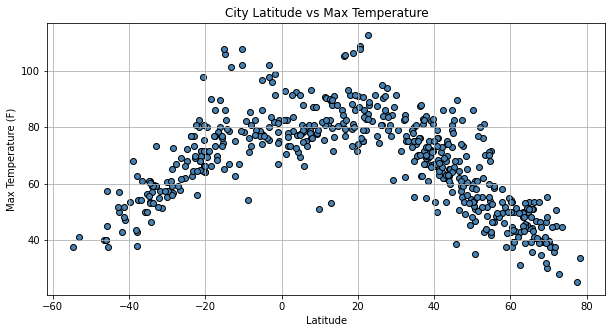

In [19]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))
# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Max Temp"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid()

output_path = os.path.join("Latitude_vs_Temperature.png")
plt.savefig(output_path)

plt.show()

## Latitude vs. Humidity Plot

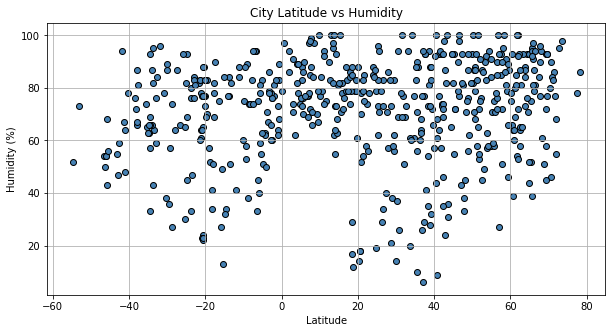

In [39]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))
# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Humidity"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()
output_path = os.path.join("Latitude_vs_Humidity.png")
plt.savefig(output_path)
plt.show()

## Latitude vs. Cloudiness Plot

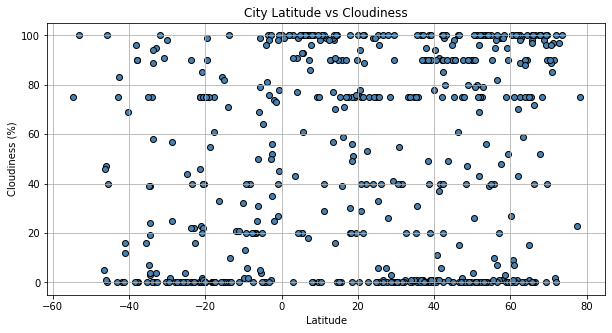

In [40]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))
# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Cloudiness"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.grid()
output_path = os.path.join("Latitude_vs_Cloudiness.png")
plt.savefig(output_path)
plt.show()

## Latitude vs. Wind Speed Plot

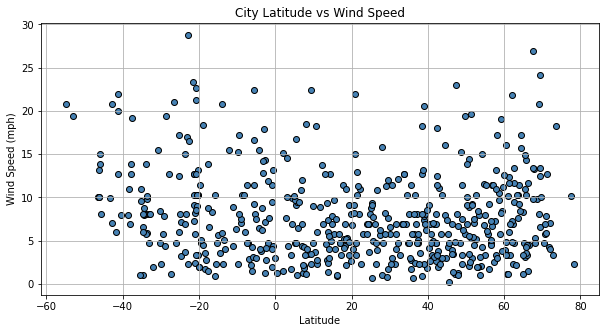

In [41]:
# Set the size of the plot (width, height) 
plt.figure(figsize=(10,5))
# Scatter Plot Format
plt.scatter(weather_data["Lat"], weather_data["Wind Speed"], marker="o", facecolors="steelblue", edgecolors="black")
plt.title("City Latitude vs Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.grid()
output_path = os.path.join("Latitude_vs_Wind.png")
plt.savefig(output_path)
plt.show()

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation coefficient (r) is -0.83
The r-squared is: 0.696928108750556
The p-value is 3.0363543847019657e-99


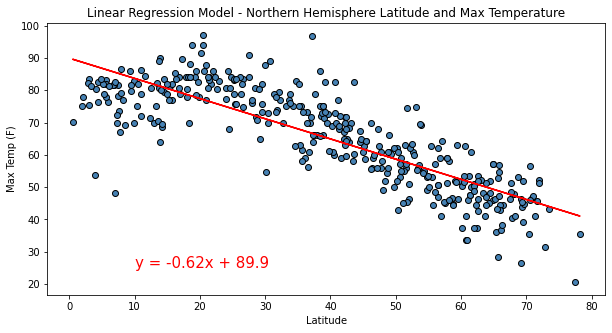

In [42]:
# Filter the dataframe to the northern hemisphere (0 to 90)
weather_data_nh = weather_data[(weather_data["Lat"] >= 0) & (weather_data['Lat'] <= 90)]

#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Max Temp"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Max Temp"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (10, 25), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Temperature.png")
plt.savefig(output_path)

plt.show()


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation coefficient (r) is 0.65
The r-squared is: 0.42529459105798983
The p-value is 1.0172298910783798e-21


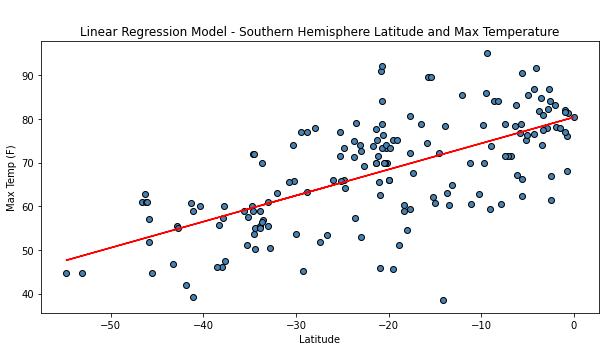

In [43]:
# Filter the dataframe to the southern hemisphere (0 to -90)
weather_data_sh = weather_data[(weather_data['Lat'] < 0)]

#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Max Temp"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Max Temp"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-50, 103), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Max Temperature")
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Temperature.png")
plt.savefig(output_path)

plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.02
The r-squared is: 0.000538349327063722
The p-value is 0.6533792027083534


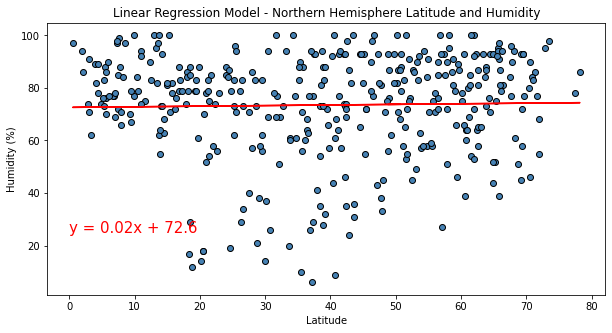

In [44]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Humidity"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Humidity"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (0, 25), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Humidity.png")
plt.savefig(output_path)

plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.1
The r-squared is: 0.010070656025291906
The p-value is 0.19556953731696483


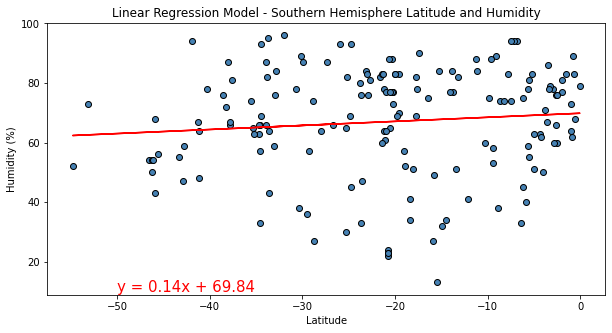

In [45]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Humidity"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Humidity"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-50, 10), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Humidity")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Humidity.png")
plt.savefig(output_path)

plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation coefficient (r) is -0.02
The r-squared is: 0.0005847201718218213
The p-value is 0.639770868944356


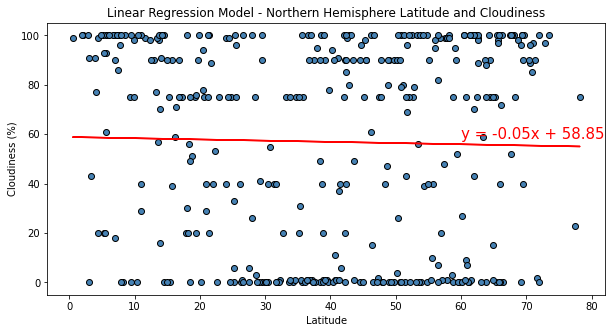

In [46]:
# Filter the dataframe to the northern hemisphere (0 to 90)
weather_data_nh = weather_data[(weather_data["Lat"] >= 0) & (weather_data['Lat'] <= 90)]

#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Cloudiness"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Cloudiness"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (60, 58), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Cloudiness.png")
plt.savefig(output_path)

plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.07
The r-squared is: 0.004717341590763197
The p-value is 0.37635574133735783


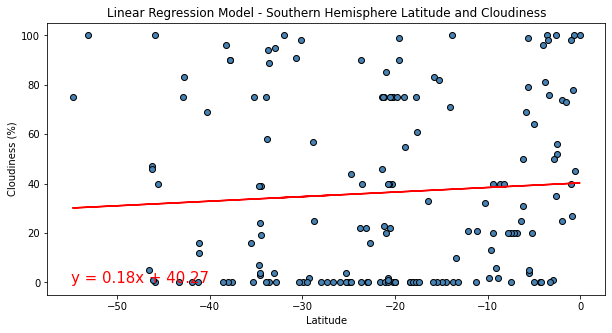

In [47]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Cloudiness"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Cloudiness"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-55, 0), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Cloudiness")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Cloudiness.png")
plt.savefig(output_path)

plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation coefficient (r) is 0.13
The r-squared is: 0.017559640461620736
The p-value is 0.010002080018163067


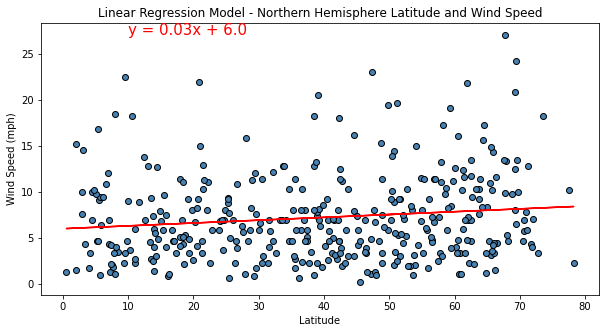

In [48]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_nh["Lat"], weather_data_nh["Wind Speed"])

x_values = weather_data_nh["Lat"]
y_values = weather_data_nh["Wind Speed"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (10, 27), fontsize=15, color="red")
plt.title("Linear Regression Model - Northern Hemisphere Latitude and Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("NH_Latitude_vs_Wind.png")
plt.savefig(output_path)

plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation coefficient (r) is -0.22
The r-squared is: 0.05039638619409237
The p-value is 0.003439580585300754


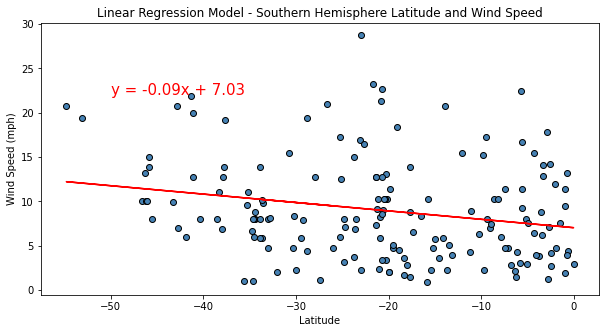

In [49]:
#Calculate Correlation
correlation = st.pearsonr(weather_data_sh["Lat"], weather_data_sh["Wind Speed"])

x_values = weather_data_sh["Lat"]
y_values = weather_data_sh["Wind Speed"]

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x (# Rooms)
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(10,5))
# Plot observations
plt.scatter(x_values, y_values, marker="o", facecolors="steelblue", edgecolors="black")

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-50, 22), fontsize=15, color="red")
plt.title("Linear Regression Model - Southern Hemisphere Latitude and Wind Speed")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")


print(f"The correlation coefficient (r) is {round(correlation[0],2)}")
print(f"The r-squared is: {rvalue**2}")
print(f"The p-value is {correlation[1]}")

output_path = os.path.join("SH_Latitude_vs_Wind.png")
plt.savefig(output_path)

plt.show()